<a href="https://colab.research.google.com/github/Maxarreaga/APS360/blob/main/init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the initilization for our APS360 Project

In [1]:
# Imports
import numpy as np
import pandas as pd 
import random 
import math 
import cv2 
import os 
import shutil
import pathlib
from google.colab import files
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import matplotlib.pyplot as plt

In [2]:
!mkdir -p root/.kaggle/

In [6]:
def get_kaggle_data():
  print('Upload Kaggle api token :')
  files.upload()
  !pip install -q kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json 

  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

get_kaggle_data()

Upload Kaggle api token :


Saving kaggle.json to kaggle (1).json
kaggle.json
 98% 599M/612M [00:09<00:00, 60.5MB/s]
100% 612M/612M [00:09<00:00, 65.8MB/s]


In [7]:
tran = transforms.Compose([transforms.Resize((32,32)),
                           transforms.Grayscale(),
                           transforms.RandomAffine(degrees=20,translate=(0,0.1),scale=(1,1.2)),
                           #transforms.Normalize((0.5,),(0.5,)),
                           transforms.ToTensor()
                           ])

In [8]:
image_datasets = torchvision.datasets.ImageFolder('/content/Data/Train', transform=tran)

num_images = len(image_datasets)
train_split_val = round(num_images*0.75)


train_set, val_set = torch.utils.data.random_split(image_datasets,[train_split_val,num_images-train_split_val])
print('Train Set: ', len(train_set))
print('Validation Set: ', len(val_set))

Train Set:  29407
Validation Set:  9802


In [9]:
# Creating DataLoader 
batch_size = 100
num_workers = 1
print("trainSet Columns = {}", train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


trainSet Columns = {} <torch.utils.data.dataset.Subset object at 0x7fe717a16810>


In [10]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    """

    # From tutorial
    correct,total = 0, 0
    for img, labels in data:
      result = model(img)
      pred = result.max(1,keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += labels.shape[0]
    accuracy = correct/total
    return accuracy

In [11]:
# 
class GTSRBClassifier(nn.Module):
  def __init__(self):
    self.name = "GTSRBClassifier"
    super(GTSRBClassifier,self).__init__()
    self.conv1 = nn.Conv2d(1,32,3) #format is in (1 if greyscale 3 if rgb),out channel third number, kernel
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,64,3)
    self.conv3 = nn.Conv2d(64,128,3)
    self.fc1 = nn.Linear(2*2*128,64)
    self.fc2 = nn.Linear(64,43)

  def forward(self,image):
    image = self.pool(F.relu(self.conv1(image)))
    image = self.pool(F.relu(self.conv2(image)))
    x = self.pool(F.relu(self.conv3(image)))
    #print("shape x= {}",x.shape)
    x = x.view(x.size(0), -1) #flattening
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)
    return x

In [12]:
# Curve Plotting
def plotCurve(xData,yData,lineLabel,loss=False):
  plt.plot(xData,yData,label=lineLabel)
  plt.xlabel("Epochs")
  if(loss==True):
    plt.ylabel("Loss")
    plt.title("Epochs vs Loss")
  else:
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Accuracy")


# Training Loop
def train(model, train_loader, valid_loader,batch_size=64, num_epochs=5, learning_rate=1e-4,plot=True):
    
  
    # set up  
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Creation of arrays for data recording
    trainingLosses = []
    validationLosses = []
    trainingAccuracy = []
    validationAccuracy = []
    iterations = []

    # Training
    for epoch in range(num_epochs):
        # Train Loop
        print("entered training")
        for data,labels  in train_loader:
            #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(data)
            loss = criterion(recon, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        trainingLosses.append(loss)
        trainAccuracy = get_accuracy(model,train_loader)
        trainingAccuracy.append(trainAccuracy)
        iterations.append(epoch)
        # get validation data
        print("exited training")
        #Validation loop
        print("entered validation")
        for data,labels in valid_loader:
          #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(data)
          validationLoss = criterion(recon, labels)
        validationLosses.append(validationLoss)
        validAcc = get_accuracy(model,valid_loader)
        validationAccuracy.append(validAcc)
        print("Epoch {} ended".format(epoch))
        print("current Training Loss {}, current validation Loss {} ".format(loss,validationLoss))
        print("current Training Accuracy {}, current validation Accuracy {} ".format(trainAccuracy,validAcc))
        PATH = "model_{}batchSize{}LearningRate{}Epoch{}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), PATH)

    #Plotting results
    if(plot == True):
        plotCurve(xData=iterations,yData=trainingLosses,lineLabel="Training",loss=True)
        plotCurve(xData=iterations,yData=validationLosses,lineLabel="Validation",loss=True)
        plt.legend()
        plt.show()
          
        plotCurve(xData=iterations,yData=trainingAccuracy,lineLabel="Training",loss=False)
        plotCurve(xData=iterations,yData=validationAccuracy,lineLabel="Validation",loss=False)
        plt.legend()
        plt.show()

    print("Final training accuracy: {} \n final validation accuracy: {} \n final training loss: {} \n final validation loss: {}".format(trainAccuracy,validAcc,loss,validationLoss))

entered training
exited training
entered validation
Epoch 0 ended
current Training Loss 1.9928910732269287, current validation Loss 1.8362250328063965 
current Training Accuracy 0.3534872649369198, current validation Accuracy 0.353193225872271 


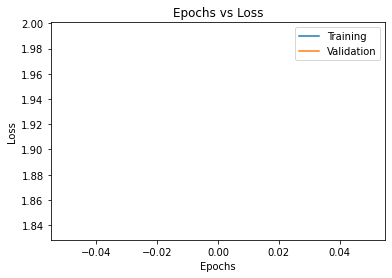

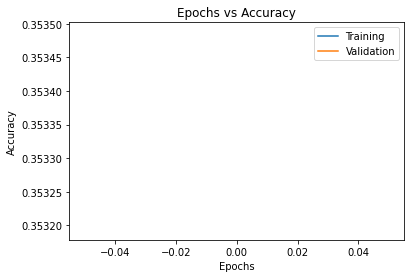

Final training accuracy: 0.3534872649369198 
 final validation accuracy: 0.353193225872271 
 final training loss: 1.9928910732269287 
 final validation loss: 1.8362250328063965


In [13]:
#running the actual loop
model = GTSRBClassifier()
batch_size = 512
epochs = 1
learningRate = 3e-3
#print(type(train_loader))
train(model=model,train_loader=train_loader,valid_loader=val_loader,batch_size=batch_size,num_epochs=epochs,learning_rate=learningRate,plot=True)